# Train-test split and sampling

In [1]:
# Load feature dataset
import pandas as pd
total= pd.read_excel('../Train_test_data/Audio_features_echolalia.xlsx')

In [2]:
# Split in train and test set
test_ids= ['9696-18','9702-04','9699-28','9699-39']

train= total.loc[total['child_ID'].isin(test_ids)== False]
test= total.loc[total['child_ID'].isin(test_ids)== True]

In [3]:
print(f'Shape of the train set before sampling: {train.shape}')
print(f'Shape of the test set: {test.shape}')

Shape of the train set before sampling: (3070, 14)
Shape of the test set: (677, 14)


In [4]:
print(f"""
Class distribution in train set before sampling:
{train['gs_label'].value_counts()}""")


Class distribution in train set before sampling:
non-echolalic    2674
echolalic         396
Name: gs_label, dtype: int64


In [5]:
ratio_train= train.loc[train['gs_label']=='echolalic'].shape[0]/ train.shape[0]

print(f"""
Ratio of echolalic utterance pairs in train set before sampling:
{ratio_train}""")


Ratio of echolalic utterance pairs in train set before sampling:
0.1289902280130293


In [6]:
print(f"""
Class distribution in test set:
{test['gs_label'].value_counts()}""")


Class distribution in test set:
non-echolalic    581
echolalic         96
Name: gs_label, dtype: int64


In [7]:
ratio_test= test.loc[test['gs_label']=='echolalic'].shape[0] / test.shape[0]

print(f"""
Ratio of echolalic utterance pairs in test set:
{ratio_test}""")


Ratio of echolalic utterance pairs in test set:
0.14180206794682423


In [8]:
X_train_total= train.loc[:,'DTW_mfcc': 'DTW_combined']
X_test= test.loc[:,'DTW_mfcc': 'DTW_combined']

In [9]:
y_train= train['gs_label']
y_test= test['gs_label']

In [10]:
# SMOTE-ENN over- and undersampling
from imblearn.combine import *
from imblearn.under_sampling import *

SE= SMOTEENN(sampling_strategy= 0.6)
X_train_total, y_train= SE.fit_resample(X_train_total, y_train)
print(f"""
Class distribution in train set before sampling:
{y_train.value_counts()}""")


Class distribution in train set before sampling:
non-echolalic    2674
echolalic         396
Name: gs_label, dtype: int64


In [11]:
print(f"""
Rows in the train set after sampling: {X_train_total.shape[0]}""")


Rows in the train set after sampling: 2614


In [12]:
ratio_train_total=y_train.value_counts()[1]/y_train.shape[0]
print(f"""
Ratio of echolalic utterance pairs in sampled train set:
{ratio_train_total}""")


Ratio of echolalic utterance pairs in sampled train set:
0.4495026778882938


# Training and evaluation

In [6]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix,mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, datasets
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [86]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.feature_selection import SelectKBest

def get_best_params(model_kind, n_splits=10, param_grid=None, features=None, positive_class='echolalic'):
    """Takes as input a classifier object, the parameter grid for a GridSearch, a nested list of feature sets and
    the positive class of the classification task,
    performs nested stratified cross validation (outer folds: 10, inner folds:2),
    and returns a dictionary containing the best combination of parameters and feature sets (from F1-score),
    the (two) most informative features and the maximum score obtained (= with the best parameters and feature sets,
    the averaged F1-score over the two inner folds of the best outer fold)    
    """
    
    
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    best_params_list = []
    all_avg_scores = []

    for fold_idx, (train_index, test_index) in enumerate(skf.split(X_train_total, y_train)):  # outer CV loop
        X_train, X_test = X_train_total.iloc[train_index], X_train_total.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        best_params_fold = {}

        for feature_set_idx, feature_set in enumerate(features):  # loop through different feature sets
            X_train_subset = X_train.loc[:, feature_set]
            nested_skf = StratifiedKFold(n_splits=2, shuffle=True)

            avg_score = 0  # initialize average f1-score for this feature set
            best_score = -1  # initialize best score for comparison
            best_params = None  # initialize best parameters for the model

            for nested_train_index, nested_test_index in nested_skf.split(X_train_subset, y_train_fold):  # inner CV loop
                X_train_nested, X_val = X_train_subset.iloc[nested_train_index], X_train_subset.iloc[nested_test_index]
                y_train_nested, y_val = y_train_fold.iloc[nested_train_index], y_train_fold.iloc[nested_test_index]
                
                 # Perform feature selection
                if len(feature_set)==1:
                    k_features=1
                else:
                    k_features=2
                selector = SelectKBest(k=k_features)  
                selector.fit(X_train_nested, y_train_nested)

                # Train model
                f1_scorer = make_scorer(lambda y_true, y_pred: f1_score(y_true, y_pred, pos_label=positive_class))
                model = GridSearchCV(model_kind, param_grid=param_grid, cv=2, scoring=f1_scorer)  # Adjust inner CV folds as needed
                model.fit(X_train_nested, y_train_nested)

                # Evaluate model
                score= model.score(X_val, y_val) 

                # Update average score and parameters if needed
                avg_score += score / 2  # divide by the number of inner folds (2 in this case)
                if score > best_score:
                    best_score = score
                    best_k = selector.get_feature_names_out()
                    best_params = model.best_params_

            best_params_fold[feature_set_idx] = {'best_score': avg_score, 'best_params': best_params, 'best_k': best_k}
            # best recall and parameters for each feature set of the outer fold

        best_params_list.append(best_params_fold)
        all_avg_scores.append(max([v['best_score'] for v in best_params_fold.values()]))
        # all_avg_scores contains the scores of the best feature set x params combo, averaged over the two folds of the inner cv
        # this list has one value per outer fold
        
        #print('One outer fold completed')

    # Select the best combination of features and parameters based on the highest average recall
    best_idx = all_avg_scores.index(max(all_avg_scores)) # get outer fold with best result
    best_features_idx = max(best_params_list[best_idx], key=lambda x: best_params_list[best_idx][x]['best_score'])
                                        # inside the fold with best result, get the index of the best feature set
    best_features = features[best_features_idx]
    best_params = best_params_list[best_idx][best_features_idx]['best_params']
    best_k = best_params_list[best_idx][best_features_idx]['best_k']
    

    return best_features, best_params, best_k, max(all_avg_scores)

In [8]:
# Store best feature sets and parameters for all models in a dictionary

model_config= {}

# feature sets:
features= [['DTW_mfcc'], ['DTW_melspectrogram'],['DTW_lpc'],
           ['DTW_mfcc','DTW_melspectrogram'], ['DTW_mfcc','DTW_lpc'], ['DTW_lpc','DTW_melspectrogram'],
           ['DTW_mfcc', 'DTW_melspectrogram', 'DTW_lpc', 'DTW_combined'],
           ['DTW_mfcc_melspectrogram'], ['DTW_mfcc_lpc'], ['DTW_melspectrogram_lpc'], ['DTW_combined'],
           ['DTW_mfcc','DTW_melspectrogram', 'DTW_mfcc_melspectrogram'], ['DTW_mfcc','DTW_lpc', 'DTW_mfcc_lpc'],
           ['DTW_lpc','DTW_melspectrogram', 'DTW_melspectrogram_lpc'],
           ['DTW_mfcc', 'DTW_melspectrogram', 'DTW_lpc', 'DTW_combined', 'DTW_mfcc_melspectrogram', 'DTW_mfcc_lpc', 'DTW_melspectrogram_lpc']
          ]

In [18]:
from sklearn.tree import DecisionTreeClassifier
DTC= DecisionTreeClassifier()
param_grid= {
    'max_depth': [None, 5, 10],  
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 2], 
    'class_weight': ['balanced'] 
}

best_features, best_params, best_k, best_avg_score = get_best_params(DTC, param_grid= param_grid, features= features)
model_config['DTC']=  {'model_obj': DecisionTreeClassifier, 'best_feature_set': best_features, 'best_k_features': best_k, 'best_params': best_params, 'best_avg_val_f1': best_avg_score}
print(model_config['DTC'])

{'model_obj': <class 'sklearn.tree._classes.DecisionTreeClassifier'>, 'best_feature_set': ['DTW_mfcc', 'DTW_melspectrogram', 'DTW_lpc', 'DTW_combined', 'DTW_mfcc_melspectrogram', 'DTW_mfcc_lpc', 'DTW_melspectrogram_lpc'], 'best_k_features': array(['DTW_mfcc', 'DTW_mfcc_lpc'], dtype=object), 'best_params': {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}, 'best_avg_val_f1': 0.7908423686405339}


In [21]:
from sklearn.neighbors import KNeighborsClassifier
KNN= KNeighborsClassifier()
param_grid= {
    'n_neighbors': [3, 5],  
    'weights': ['uniform', 'distance'],  
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'] 
}

best_features, best_params, best_k, best_avg_score = get_best_params(KNN, param_grid= param_grid, features= features)
model_config['KNN']=  {'model_obj': KNeighborsClassifier, 'best_feature_set': best_features, 'best_k_features': best_k, 'best_params': best_params, 'best_avg_val_f1': best_avg_score}

In [23]:
print(model_config['KNN'])

{'model_obj': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>, 'best_feature_set': ['DTW_mfcc', 'DTW_melspectrogram', 'DTW_lpc', 'DTW_combined', 'DTW_mfcc_melspectrogram', 'DTW_mfcc_lpc', 'DTW_melspectrogram_lpc'], 'best_k_features': array(['DTW_mfcc', 'DTW_mfcc_lpc'], dtype=object), 'best_params': {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}, 'best_avg_val_f1': 0.9086712443359475, 'test_accuracy': 0.6144756277695717, 'test_recall': 0.4479166666666667, 'test_precision': 0.17131474103585656, 'test_f1': 0.2478386167146974}


In [24]:
from sklearn.ensemble import RandomForestClassifier
RFC= RandomForestClassifier()
param_grid= {
    'n_estimators': [50, 100],  
    'max_depth': [None, 5, 10],  
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 2],  
    'class_weight': ['balanced']
}

best_features, best_params, best_k, best_avg_score = get_best_params(RFC, param_grid= param_grid, features= features)
model_config['RFC']=  {'model_obj': RandomForestClassifier, 'best_feature_set': best_features, 'best_k_features': best_k, 'best_params': best_params, 'best_avg_val_f1': best_avg_score}

In [26]:
from sklearn.svm import SVC
SVC_model= SVC()
param_grid= {
    'C': [0.01, 0.1, 1],  
    'gamma': [0.01, 0.1, 1, 10, 100],
    'probability': [True],
    'class_weight': ['balanced']
}

best_features, best_params, best_k, best_avg_score = get_best_params(SVC_model, param_grid= param_grid, features= features)
model_config['SVC']=  {'model_obj': SVC, 'best_feature_set': best_features, 'best_k_features': best_k, 'best_params': best_params, 'best_avg_val_f1': best_avg_score}
print(model_config['SVC'])

{'model_obj': <class 'sklearn.svm._classes.SVC'>, 'best_feature_set': ['DTW_mfcc', 'DTW_melspectrogram', 'DTW_lpc', 'DTW_combined', 'DTW_mfcc_melspectrogram', 'DTW_mfcc_lpc', 'DTW_melspectrogram_lpc'], 'best_k_features': array(['DTW_mfcc', 'DTW_mfcc_lpc'], dtype=object), 'best_params': {'C': 1, 'class_weight': 'balanced', 'gamma': 100, 'probability': True}, 'best_avg_val_f1': 0.8948152979398281}


In [28]:
from sklearn.linear_model import LogisticRegression
LREG= LogisticRegression()
param_grid= {
    'C': [0.01, 0.1, 1],  
    'penalty': [None, 'l2'],  
    'class_weight': ['balanced']
}

best_features, best_params, best_k, best_avg_score= get_best_params(LREG, param_grid= param_grid, features= features)
model_config['LREG']=  {'model_obj': LogisticRegression, 'best_feature_set': best_features, 'best_k_features': best_k, 'best_params': best_params, 'best_avg_val_f1': best_avg_score}
print(model_config['LREG'])

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

{'model_obj': <class 'sklearn.linear_model._logistic.LogisticRegression'>, 'best_feature_set': ['DTW_mfcc', 'DTW_melspectrogram', 'DTW_mfcc_melspectrogram'], 'best_k_features': array(['DTW_mfcc', 'DTW_mfcc_melspectrogram'], dtype=object), 'best_params': {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}, 'best_avg_val_f1': 0.647243377144495}


C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.neural_network import MLPClassifier
MLP= MLPClassifier()
param_grid = {
    'hidden_layer_sizes': [(50, 30)],
    'activation': ['logistic', 'relu'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant'],
    'max_iter': [400, 600]
}

best_features, best_params, best_k, best_avg_score= get_best_params(MLP, param_grid= param_grid, features= features)
model_config['MLP']=  {'model_obj': MLPClassifier, 'best_feature_set': best_features, 'best_k_features': best_k, 'best_params': best_params, 'best_avg_val_f1': best_avg_score}
print(model_config['MLP'])


One outer fold completed
One outer fold completed
One outer fold completed
One outer fold completed
One outer fold completed
One outer fold completed
One outer fold completed
One outer fold completed
One outer fold completed
One outer fold completed
{'model_obj': <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>, 'best_feature_set': ['DTW_mfcc', 'DTW_melspectrogram', 'DTW_lpc', 'DTW_combined', 'DTW_mfcc_melspectrogram', 'DTW_mfcc_lpc', 'DTW_melspectrogram_lpc'], 'best_k_features': array(['DTW_mfcc', 'DTW_mfcc_lpc'], dtype=object), 'best_params': {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (50, 30), 'learning_rate': 'constant', 'max_iter': 600, 'solver': 'lbfgs'}, 'best_avg_val_f1': 0.6810754189944135}


{'model_obj': <class 'sklearn.tree._classes.DecisionTreeClassifier'>, 'best_feature_set': ['DTW_mfcc', 'DTW_melspectrogram', 'DTW_lpc', 'DTW_combined', 'DTW_mfcc_melspectrogram', 'DTW_mfcc_lpc', 'DTW_melspectrogram_lpc'], 'best_k_features': array(['DTW_mfcc', 'DTW_mfcc_lpc'], dtype=object), 'best_params': {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}, 'best_avg_val_f1': 0.7908423686405339, 'test_accuracy': 0.672082717872969, 'test_recall': 0.3541666666666667, 'test_precision': 0.17525773195876287, 'test_f1': 0.23448275862068965} 

{'model_obj': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>, 'best_feature_set': ['DTW_mfcc', 'DTW_melspectrogram', 'DTW_lpc', 'DTW_combined', 'DTW_mfcc_melspectrogram', 'DTW_mfcc_lpc', 'DTW_melspectrogram_lpc'], 'best_k_features': array(['DTW_mfcc', 'DTW_mfcc_lpc'], dtype=object), 'best_params': {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}, 'best_avg_val_f1': 0.908671244335

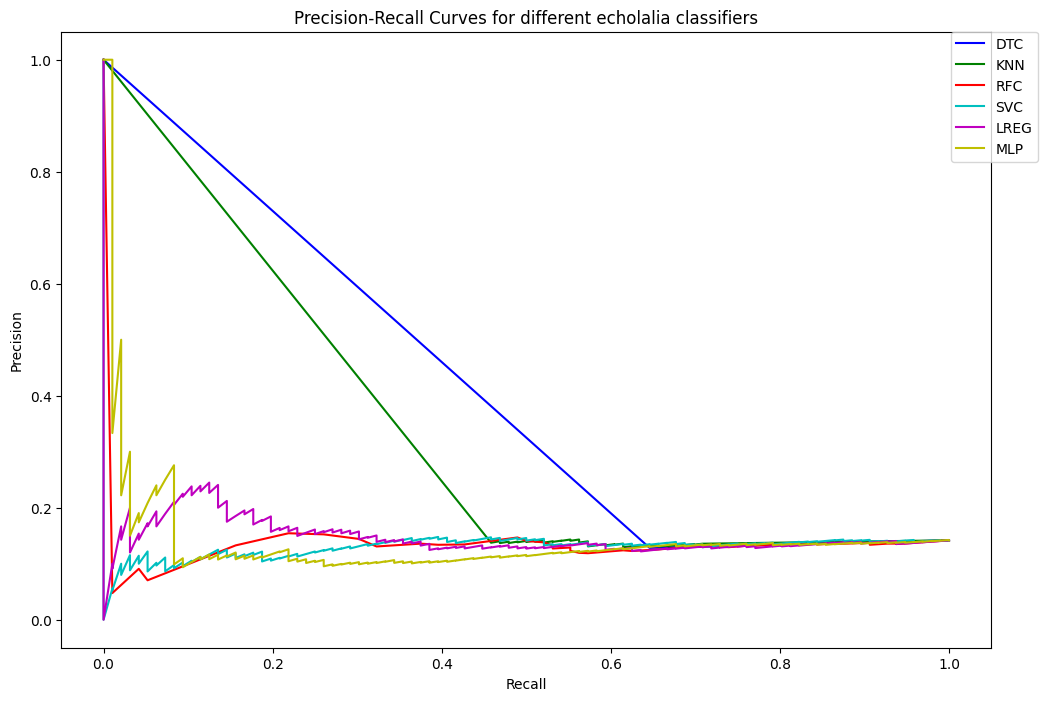

In [13]:
# Now fit the models with their best parameters and feature sets on the train set and test them on the test set:

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, precision_recall_curve

plt.figure(figsize=(12, 8))
colors = ['b', 'g', 'r', 'c', 'm','y']
i=0

for model_name, config in model_config.items():
    model_obj = config['model_obj']
    best_features = config['best_feature_set']
    best_params = config['best_params']

    # Set parameters
    model_best = model_obj().set_params(**best_params)

    # Fit the model on training data (selecting only the columns from the best feature set)
    model_best.fit(X_train_total[best_features], y_train)

    # Make predictions
    y_pred = model_best.predict(X_test[best_features])

    # Calculate metrics
    test_accuracy = accuracy_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred, pos_label='echolalic')
    test_precision = precision_score(y_test, y_pred, pos_label='echolalic')
    test_f1 = f1_score(y_test, y_pred, pos_label='echolalic')

    # Store metrics in the dictionary
    model_config[model_name]['test_accuracy'] = test_accuracy
    model_config[model_name]['test_recall'] = test_recall
    model_config[model_name]['test_precision'] = test_precision
    model_config[model_name]['test_f1'] = test_f1
    print(model_config[model_name], '\n')

    # Calculate precision-recall curve
    precision, recall, threshold = precision_recall_curve(y_test, model_best.predict_proba(X_test[best_features])[:, 1], pos_label='echolalic')

    # Plot precision-recall curve
    plt.plot(recall, precision, color=colors[i], label=model_name)
    i+=1

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for different echolalia classifiers')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.) 
plt.show()

        

In [19]:
for model, items in model_config.items():
    print('\n',model)
    for key, value in items.items():
        print(key,': ', value)


 DTC
model_obj :  <class 'sklearn.tree._classes.DecisionTreeClassifier'>
best_feature_set :  ['DTW_mfcc', 'DTW_melspectrogram', 'DTW_lpc', 'DTW_combined', 'DTW_mfcc_melspectrogram', 'DTW_mfcc_lpc', 'DTW_melspectrogram_lpc']
best_k_features :  ['DTW_mfcc' 'DTW_mfcc_lpc']
best_params :  {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
best_avg_val_f1 :  0.7908423686405339
test_accuracy :  0.672082717872969
test_recall :  0.3541666666666667
test_precision :  0.17525773195876287
test_f1 :  0.23448275862068965

 KNN
model_obj :  <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
best_feature_set :  ['DTW_mfcc', 'DTW_melspectrogram', 'DTW_lpc', 'DTW_combined', 'DTW_mfcc_melspectrogram', 'DTW_mfcc_lpc', 'DTW_melspectrogram_lpc']
best_k_features :  ['DTW_mfcc' 'DTW_mfcc_lpc']
best_params :  {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
best_avg_val_f1 :  0.9086712443359475
test_accuracy :  0.5775480059084195
test_rec

# Get best threshold for best model and store trained model

In [27]:
model_config={}
from sklearn.linear_model import LogisticRegression
model_config['LREG']= {'model_obj': LogisticRegression, 'best_feature_set': ['DTW_mfcc', 'DTW_melspectrogram', 'DTW_mfcc_melspectrogram'], 'best_params': {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}}

In [28]:
# Get precision, recall and F1 for different thresholds for the best classifier (Logistic Regression)

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, precision_recall_curve


config= model_config['LREG']
model_obj = config['model_obj']
best_features = config['best_feature_set']
best_params = config['best_params']

# Set parameters
model_best = model_obj().set_params(**best_params)

# Fit the model on training data
model_best.fit(X_train_total[best_features], y_train)


# Calculate precision-recall curve
precision, recall, threshold = precision_recall_curve(y_test, model_best.predict_proba(X_test[best_features])[:, 1], pos_label='echolalic')

# Store data in dataframe
df= pd.DataFrame(columns= ['Precision','Recall','F1','Threshold'])
i=0
for pr, rec, thr in zip(precision, recall, threshold):
    f1= 2*pr*rec/(pr+rec)
    df.loc[i]= [pr, rec, f1, thr]
    i+=1
        

C:\Users\Marie Kolenberg\AppData\Local\Temp\ipykernel_6548\3192571326.py:26: RuntimeWarning: invalid value encountered in scalar divide
  f1= 2*pr*rec/(pr+rec)
C:\Users\Marie Kolenberg\AppData\Local\Temp\ipykernel_6548\3192571326.py:26: RuntimeWarning: invalid value encountered in scalar divide
  f1= 2*pr*rec/(pr+rec)
C:\Users\Marie Kolenberg\AppData\Local\Temp\ipykernel_6548\3192571326.py:26: RuntimeWarning: invalid value encountered in scalar divide
  f1= 2*pr*rec/(pr+rec)
C:\Users\Marie Kolenberg\AppData\Local\Temp\ipykernel_6548\3192571326.py:26: RuntimeWarning: invalid value encountered in scalar divide
  f1= 2*pr*rec/(pr+rec)
C:\Users\Marie Kolenberg\AppData\Local\Temp\ipykernel_6548\3192571326.py:26: RuntimeWarning: invalid value encountered in scalar divide
  f1= 2*pr*rec/(pr+rec)
C:\Users\Marie Kolenberg\AppData\Local\Temp\ipykernel_6548\3192571326.py:26: RuntimeWarning: invalid value encountered in scalar divide
  f1= 2*pr*rec/(pr+rec)
C:\Users\Marie Kolenberg\AppData\Local\T

In [98]:
df.loc[df['Precision']== df['Precision'].max()] # Maximum value for precision

,Precision,Recall,F1,Threshold
630,0.255319,0.125,0.167832,0.701386


In [99]:
df.loc[df['Recall']== df['Recall'].max()] # Maximum value for recall

,Precision,Recall,F1,Threshold
0,0.141802,1.0,0.248383,0.270082


In [62]:
df.loc[df['F1']== df['F1'].max()] # Maximum value for F1-score

,Precision,Recall,F1,Threshold
0,0.141802,1.0,0.248383,0.300936


In [33]:
max_f1= df.loc[df['Precision']> 0.16, 'F1'].max() # Get max F1-score with acceptable precision

In [105]:
threshold= float(df.loc[(df['F1']> 0.2) & (df['Precision']> 0.16) & (df['F1']== max_f1), 'Threshold']) # Store threshold

In [106]:
threshold

0.5610258542626617

In [100]:
def predict(model, X, threshold):
    probs = model.predict_proba(X) 
    return (probs[:, 1] > threshold).astype(int)

model_best = model_obj().set_params(**best_params)
model_best.fit(X_train_total[best_features], y_train)
y_pred= predict(model_best, X= X_test[best_features], threshold=threshold)

In [107]:
# Store best classifier and configuration in pickle
best_model_config= {'model_obj': model_best, 'best_features': best_features, 'threshold': threshold}
with open('Trained_best_classifier_echolalia.pkl', 'wb') as handle:
    pickle.dump(best_model_config, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Train logistic regression on original (imbalanced) dataset + test

In [84]:
total= pd.read_excel('Train_test_data/Audio_features_echolalia.xlsx')
test_ids= ['9696-18','9702-04','9699-28','9699-39']

train= total.loc[total['child_ID'].isin(test_ids)== False]
test= total.loc[total['child_ID'].isin(test_ids)== True]

X_train_total= train.loc[:,'DTW_mfcc': 'DTW_combined']
X_test= test.loc[:,'DTW_mfcc': 'DTW_combined']

y_train= train['gs_label']
y_test= test['gs_label']

In [87]:
from sklearn.linear_model import LogisticRegression
LREG= LogisticRegression()
param_grid= {
    'C': [0.01, 0.1, 1],  # Regularization parameter
    'penalty': [None, 'l2'],  # Penalty term
    'class_weight': ['balanced']
}

best_features, best_params, best_k, best_avg_score= get_best_params(LREG, param_grid= param_grid, features= features)
model_config_LREG=  {'model_obj': LogisticRegression, 'best_feature_set': best_features, 'best_k_features': best_k, 'best_params': best_params, 'best_avg_val_f1': best_avg_score}
print(model_config_LREG)

{'model_obj': <class 'sklearn.linear_model._logistic.LogisticRegression'>, 'best_feature_set': ['DTW_mfcc', 'DTW_lpc', 'DTW_mfcc_lpc'], 'best_k_features': array(['DTW_mfcc', 'DTW_mfcc_lpc'], dtype=object), 'best_params': {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2'}, 'best_avg_val_f1': 0.287808476714024}


In [91]:
best_features = model_config_LREG['best_feature_set']
best_params = model_config_LREG['best_params']

# Set parameters
model_best = model_obj().set_params(**best_params)

# Fit the model on training data
model_best.fit(X_train_total[best_features], y_train)

# Make predictions
y_pred = model_best.predict(X_test[best_features])

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred, pos_label='echolalic')
test_precision = precision_score(y_test, y_pred, pos_label='echolalic')
test_f1 = f1_score(y_test, y_pred, pos_label='echolalic')

# Store metrics in the dictionary
model_config_LREG['test_accuracy'] = test_accuracy
model_config_LREG['test_recall'] = test_recall
model_config_LREG['test_precision'] = test_precision
model_config_LREG['test_f1'] = test_f1

for var, value in model_config_LREG.items():
    print(var, ':', value, '\n')
# Very similar to metrics of model based on sampled data
# but lower validation f1 => SMOTE may contribute to overfitting

model_obj : <class 'sklearn.linear_model._logistic.LogisticRegression'> 

best_feature_set : ['DTW_mfcc', 'DTW_lpc', 'DTW_mfcc_lpc'] 

best_k_features : ['DTW_mfcc' 'DTW_mfcc_lpc'] 

best_params : {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2'} 

best_avg_val_f1 : 0.287808476714024 

test_accuracy : 0.5819793205317577 

test_recall : 0.53125 

test_precision : 0.17647058823529413 

test_f1 : 0.2649350649350649 

